# Detecting Payment Fraud

In a 2016 study, it was estimated that credit card fraud was responsible for over 20 billion dollars in loss, worldwide. Accurately detecting cases of fraud is an ongoing area of research.

## Labeled Data¶
The payment fraud data set (Dal Pozzolo et al. 2015) was downloaded from Kaggle. This has features and labels for thousands of credit card transactions, each of which is labeled as fraudulent or valid. In this notebook, we'd like to train a model based on the features of these transactions so that we can predict risky or fraudulent transactions in the future.

* It is worth noticing that the column features V1-V28 are the relevant components after being processed and refined by PCA. Kaggle stated that they cannot disclose the features due to confidentiality issue. For such reason, we will work directly with the features without doing any further feature engineering. 

## Binary Classification
Since we have true labels to aim for, we'll take a supervised learning approach and train a binary classifier to sort data into one of our two transaction classes: fraudulent or valid. We'll train a model on training data and see how well it generalizes on some test data.

#### The notebook will be broken down into a few steps:

1) Loading and exploring the data

2) Splitting the data into train/test sets

3) Defining and training a LinearLearner, binary classifier

4) Making improvements on the model

5) Evaluating and comparing model test performance

In [1]:
# First, download all of the necessary libraries
import os

import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd

In [2]:
# get the data
df = pd.read_csv('creditcard.csv')
df.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


### Exploratory Data Analysis

It is worth pointing out that the time feature has bimodal distribution, which we can prove by plotting it in a histogram

# Plot a histogram of Time feature

count, bin_edges = np.histogram(df['Time']) # create bin ranges and frequency count
df['Time'].plot(kind='hist',color='darkblue',figsize = (7,4), xticks = bin_edges)

plt.title('Histogram of Time Elapses between transactions')
plt.xlabel('Number of seconds')
plt.ylabel('Frequency')

plt.show()

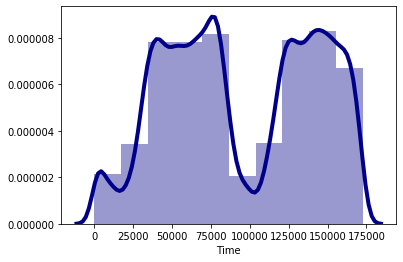

In [3]:
import seaborn as sns

count,bin_edges = np.histogram(df['Time'])
sns.distplot(df['Time'], hist=True, kde=True, 
             bins=bin_edges, color = 'darkblue',
             kde_kws={'linewidth': 4})

In [4]:
# Calculate the percentage of Fradulent transactions:

def percent_fraud(df):
    return (len(df[df.Class==1])/len(df['Class']))*100

# call the function to calculate the fraud percentage
percentage = percent_fraud(df)

print('Fraudulent percentage = ', percentage)
print('Total # of fraudulent pts: ', percentage*df.shape[0])
print('Out of (total) pts: ', df.shape[0])

Fraudulent percentage =  0.1727485630620034
Total # of fraudulent pts:  49200.0
Out of (total) pts:  284807


### Split into train/test datasets

In [6]:
# First, randomly split the dataset into the training and testing sets.

from sklearn.model_selection import train_test_split

features = df.columns.values
X = df[features[:-1]]
y = df[features[-1]]

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=33)

In [7]:
print('Number of testing data: ',(len(X_test),len(y_test)))
print('Number of training data: ', (len(X_train),len(y_train)))

Number of testing data:  (56962, 56962)
Number of training data:  (227845, 227845)


### Data Modelling

***For the purpose of this project, we pick a model that produces binary classification prediction. I am going to try 3 supervised classification algorithms namely Logistics Regression, Naives Bayes Theorem, and Random Forest (based on CART). We will then evaluate them and pick the best one.***

#### 1) Naive Bayes Theorem

In [8]:
from sklearn.naive_bayes import GaussianNB
gnb=GaussianNB()

gnb.fit(X_train,y_train)
gnb_predicted_y = gnb.predict(X_test)

In [9]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

print('Confusion Matrix for Naive Bayes: \n', confusion_matrix(y_test,gnb_predicted_y))
print('Accuracy Score: ',accuracy_score(y_test,gnb_predicted_y))

Confusion Matrix for Naive Bayes: 
 [[56486   373]
 [   39    64]]
Accuracy Score:  0.9927671078964924


#### 2) Logistic Regression

In [10]:
from sklearn.linear_model import LogisticRegression
lgr=LogisticRegression()

lgr.fit(X_train,y_train)
lgr_predicted_y = lgr.predict(X_test)

c:\users\tram ngo\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [11]:
print(lgr.predict_proba(X_test[:10]))

[[9.99971598e-01 2.84019578e-05]
 [9.99991478e-01 8.52159469e-06]
 [9.99937532e-01 6.24684477e-05]
 [9.99989506e-01 1.04938823e-05]
 [9.99989950e-01 1.00498640e-05]
 [9.96623851e-01 3.37614902e-03]
 [9.99967368e-01 3.26317022e-05]
 [9.99980392e-01 1.96079770e-05]
 [9.99999992e-01 7.64771223e-09]
 [9.99980876e-01 1.91236378e-05]]


In [12]:
print('Confusion Matrix for Logistic Regression: \n', confusion_matrix(y_test,lgr_predicted_y))
print('Accuracy Score: ',accuracy_score(y_test,lgr_predicted_y))

Confusion Matrix for Logistic Regression: 
 [[56846    13]
 [   41    62]]
Accuracy Score:  0.9990519995786665


#### 3) Random Forest 

In [13]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=0) 
                            # n_estimators is the number of trees in the forest, by default is equal to 100 
clf.fit(X_train,y_train)
clf_predicted_y = clf.predict(X_test)

In [14]:
print('Confusion Matrix for Random Forest: \n', confusion_matrix(y_test,clf_predicted_y))
print('Accuracy Score: ',accuracy_score(y_test,clf_predicted_y))

Confusion Matrix for Random Forest: 
 [[56851     8]
 [   37    66]]
Accuracy Score:  0.9992099996488887


### Model Tuning: Managing Class Imbalance

We are going to use the strategy of Random Over-sampling, meaning that we will replicate the few class 0 instances and add them to the datasets to make them more representative within the model. 

In [35]:
# Separate the classes
df_fraud_class = y_train[y_train==1]
df_nonfraud_class = y_train[y_train==0]

# Count the instances:
count_class_0 = len(df_nonfraud_class)
count_class_1 = len(df_fraud_class)

df_fraud_class = df_fraud_class.sample(count_class_1, replace=True)
df_nonfraud_class = df_nonfraud_class.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_fraud_class, df_nonfraud_class], axis=0)

In [36]:
# Train the model using the new training sets
# Since Random Forest performs the best in the dataset below, we are only going to implement the algorithm here

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=0) 
                            # n_estimators is the number of trees in the forest, by default is equal to 100 
clf.fit(X_train,df_test_over)
clf_predicted_y = clf.predict(X_test)

In [37]:
print('Confusion Matrix for Random Forest: \n', confusion_matrix(y_test,clf_predicted_y))
print('Accuracy Score: ',accuracy_score(y_test,clf_predicted_y))

Confusion Matrix for Random Forest: 
 [[56859     0]
 [  103     0]]
Accuracy Score:  0.9981917769741231
